In [24]:
import torch
from torchvision import datasets, transforms
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

import time

from vae import VAE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 32
data_dir = "../data/all-dogs/"
cropped_data_dir = "../data/all-dogs-cropped/"

def get_data_loader(path):

    random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_data = datasets.ImageFolder(path, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    
    return train_loader
                                         
# imgs, label = next(iter(train_loader))
# imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [4]:
data_loader = get_data_loader(data_dir)
cropped_data_loader = get_data_loader(cropped_data_dir)

In [5]:
imgs, _ = next(iter(data_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

imgs_cropped, _ = next(iter(cropped_data_loader))
imgs_cropped = imgs_cropped.numpy().transpose(0, 2, 3, 1)

In [28]:
def train(model, train_loader, optimizer, epochs, imgs):
    
    mse_losses = []
    kld_losses = []

    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        print('Starting epoch: {}'.format(epoch))

        mse_loss_total = 0
        kld_loss_total = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            mse_loss, kld_loss = model.loss_function(recon_batch, data, mu, logvar)

            mse_loss_total += mse_loss
            kld_loss_total += kld_loss

            loss = mse_loss + kld_loss

            loss.backward()
            optimizer.step()
            
        mse_losses.append(mse_loss_total)
        kld_losses.append(kld_loss_total)

        print("Loss: Total: {}, MSE: {}, KLD: {}".format(mse_loss_total+kld_loss_total, mse_loss_total, kld_loss_total))
        print('Time for epoch {}: {}'.format(epoch, time.time()-start_time))

        model.eval()
        recon_img, _, _ = model(torch.tensor(imgs[:1].transpose(0, 3, 1, 2)).to(device))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

        plt.imshow((img+1.)/2.)
        plt.show()
        
    return mse_losses, kld_losses

## Non cropped images

In [14]:
lr = 1e-3
epochs = 15
latent_dim = 32

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

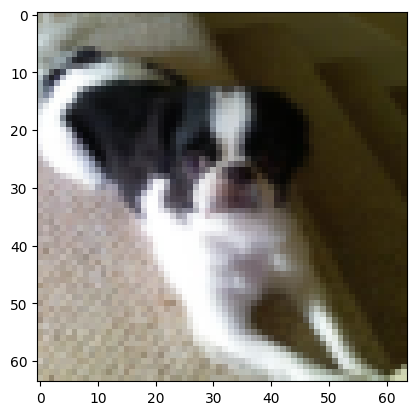

In [15]:
plt.imshow((imgs[0]+1)/2)
plt.show()

Starting epoch: 1
Loss: Total: 1558.933837890625, MSE: 1467.5802001953125, KLD: 91.35358428955078
Time for epoch 1: 132.2630045413971


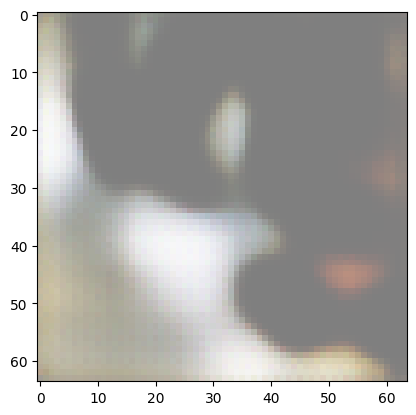

Starting epoch: 2
Loss: Total: 1323.8179931640625, MSE: 1308.480712890625, KLD: 15.337240219116211
Time for epoch 2: 119.24443531036377


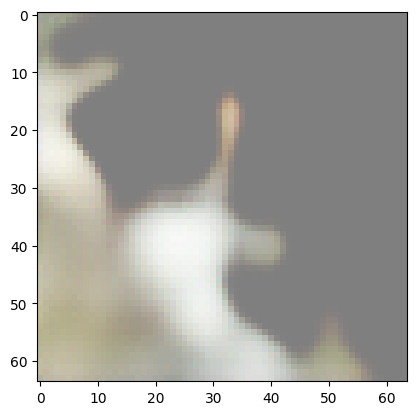

Starting epoch: 3
Loss: Total: 1293.706787109375, MSE: 1277.5623779296875, KLD: 16.144384384155273
Time for epoch 3: 120.52774953842163


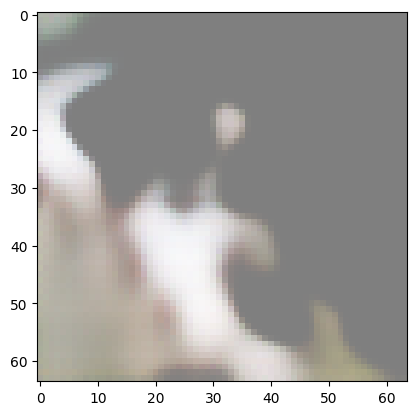

Starting epoch: 4
Loss: Total: 1282.4476318359375, MSE: 1265.072509765625, KLD: 17.375072479248047
Time for epoch 4: 122.37205100059509


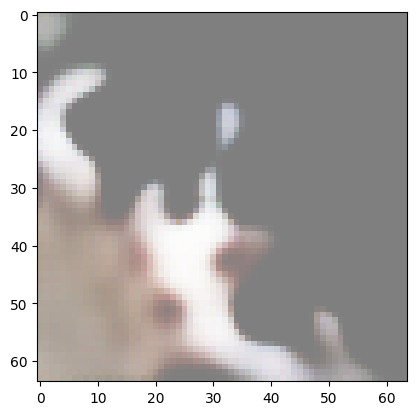

Starting epoch: 5
Loss: Total: 1269.6279296875, MSE: 1251.296142578125, KLD: 18.331762313842773
Time for epoch 5: 123.70252084732056


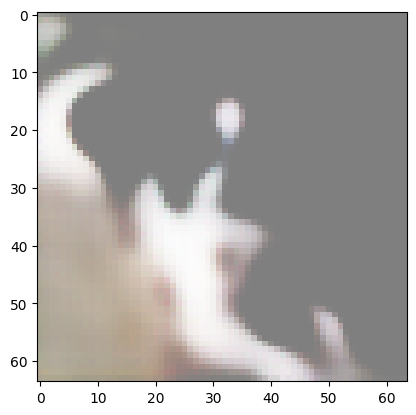

Starting epoch: 6
Loss: Total: 1265.85546875, MSE: 1246.85302734375, KLD: 19.00244140625
Time for epoch 6: 141.26927947998047


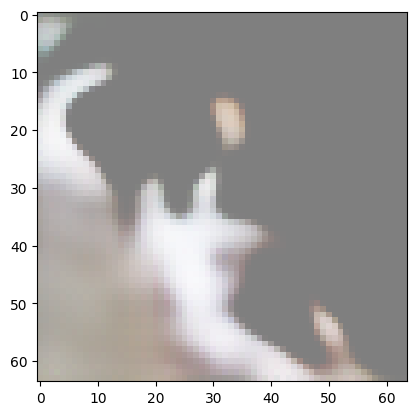

Starting epoch: 7
Loss: Total: 1262.541259765625, MSE: 1243.09375, KLD: 19.447452545166016
Time for epoch 7: 136.46021556854248


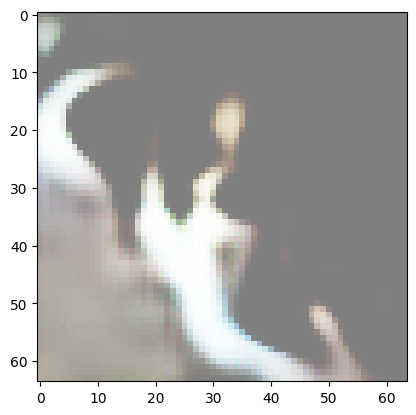

Starting epoch: 8
Loss: Total: 1257.933837890625, MSE: 1237.857177734375, KLD: 20.076642990112305
Time for epoch 8: 129.93905925750732


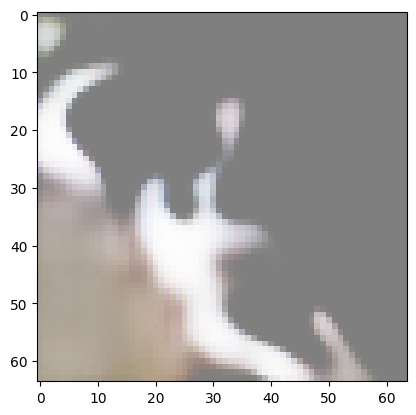

Starting epoch: 9
Loss: Total: 1256.9600830078125, MSE: 1236.1129150390625, KLD: 20.847166061401367
Time for epoch 9: 126.82736277580261


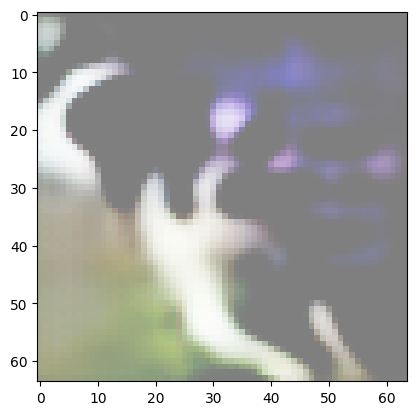

Starting epoch: 10
Loss: Total: 1252.5533447265625, MSE: 1231.9234619140625, KLD: 20.629833221435547
Time for epoch 10: 125.48053097724915


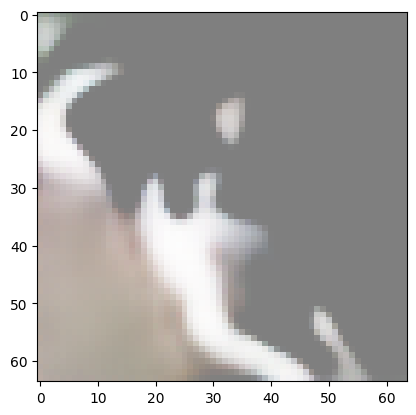

Starting epoch: 11
Loss: Total: 1250.231201171875, MSE: 1229.6605224609375, KLD: 20.570676803588867
Time for epoch 11: 124.47194957733154


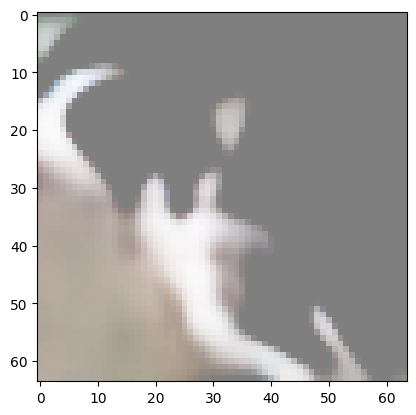

Starting epoch: 12
Loss: Total: 1246.85009765625, MSE: 1226.08642578125, KLD: 20.763717651367188
Time for epoch 12: 124.79721021652222


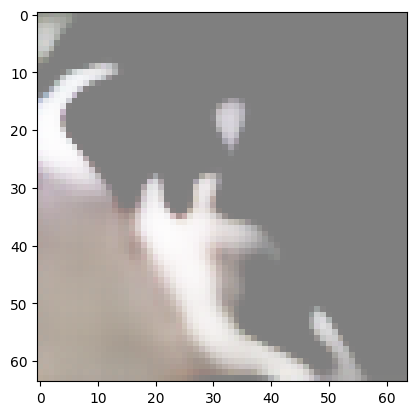

Starting epoch: 13
Loss: Total: 1246.3560791015625, MSE: 1225.4462890625, KLD: 20.90978240966797
Time for epoch 13: 125.06299138069153


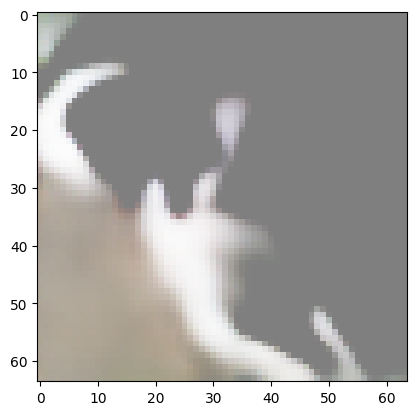

Starting epoch: 14
Loss: Total: 1246.4566650390625, MSE: 1225.284423828125, KLD: 21.172271728515625
Time for epoch 14: 125.56413722038269


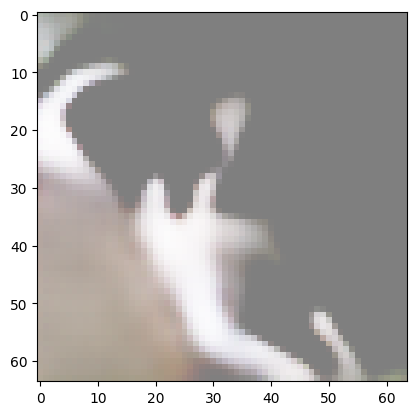

Starting epoch: 15
Loss: Total: 1243.6412353515625, MSE: 1222.6441650390625, KLD: 20.9970703125
Time for epoch 15: 125.5987331867218


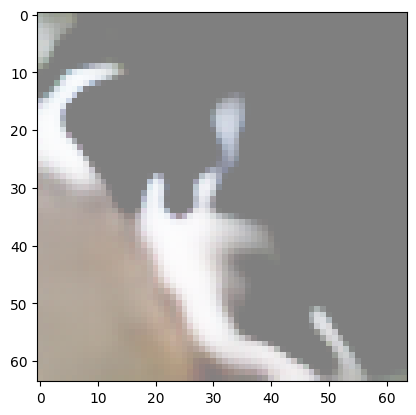

Starting epoch: 16
Loss: Total: 1244.4833984375, MSE: 1223.354248046875, KLD: 21.129196166992188
Time for epoch 16: 128.01205229759216


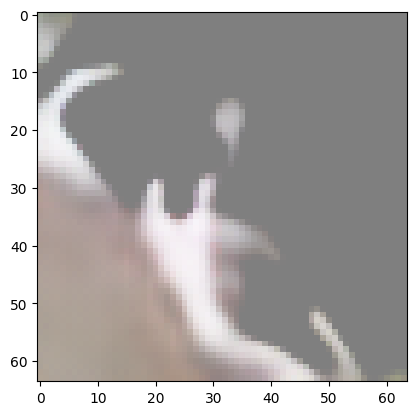

Starting epoch: 17


KeyboardInterrupt: 

In [16]:
mse_losses, kld_losses = train(model, data_loader, optimizer, epochs, imgs)

In [ ]:
# losses = {
#     'mse'
# }

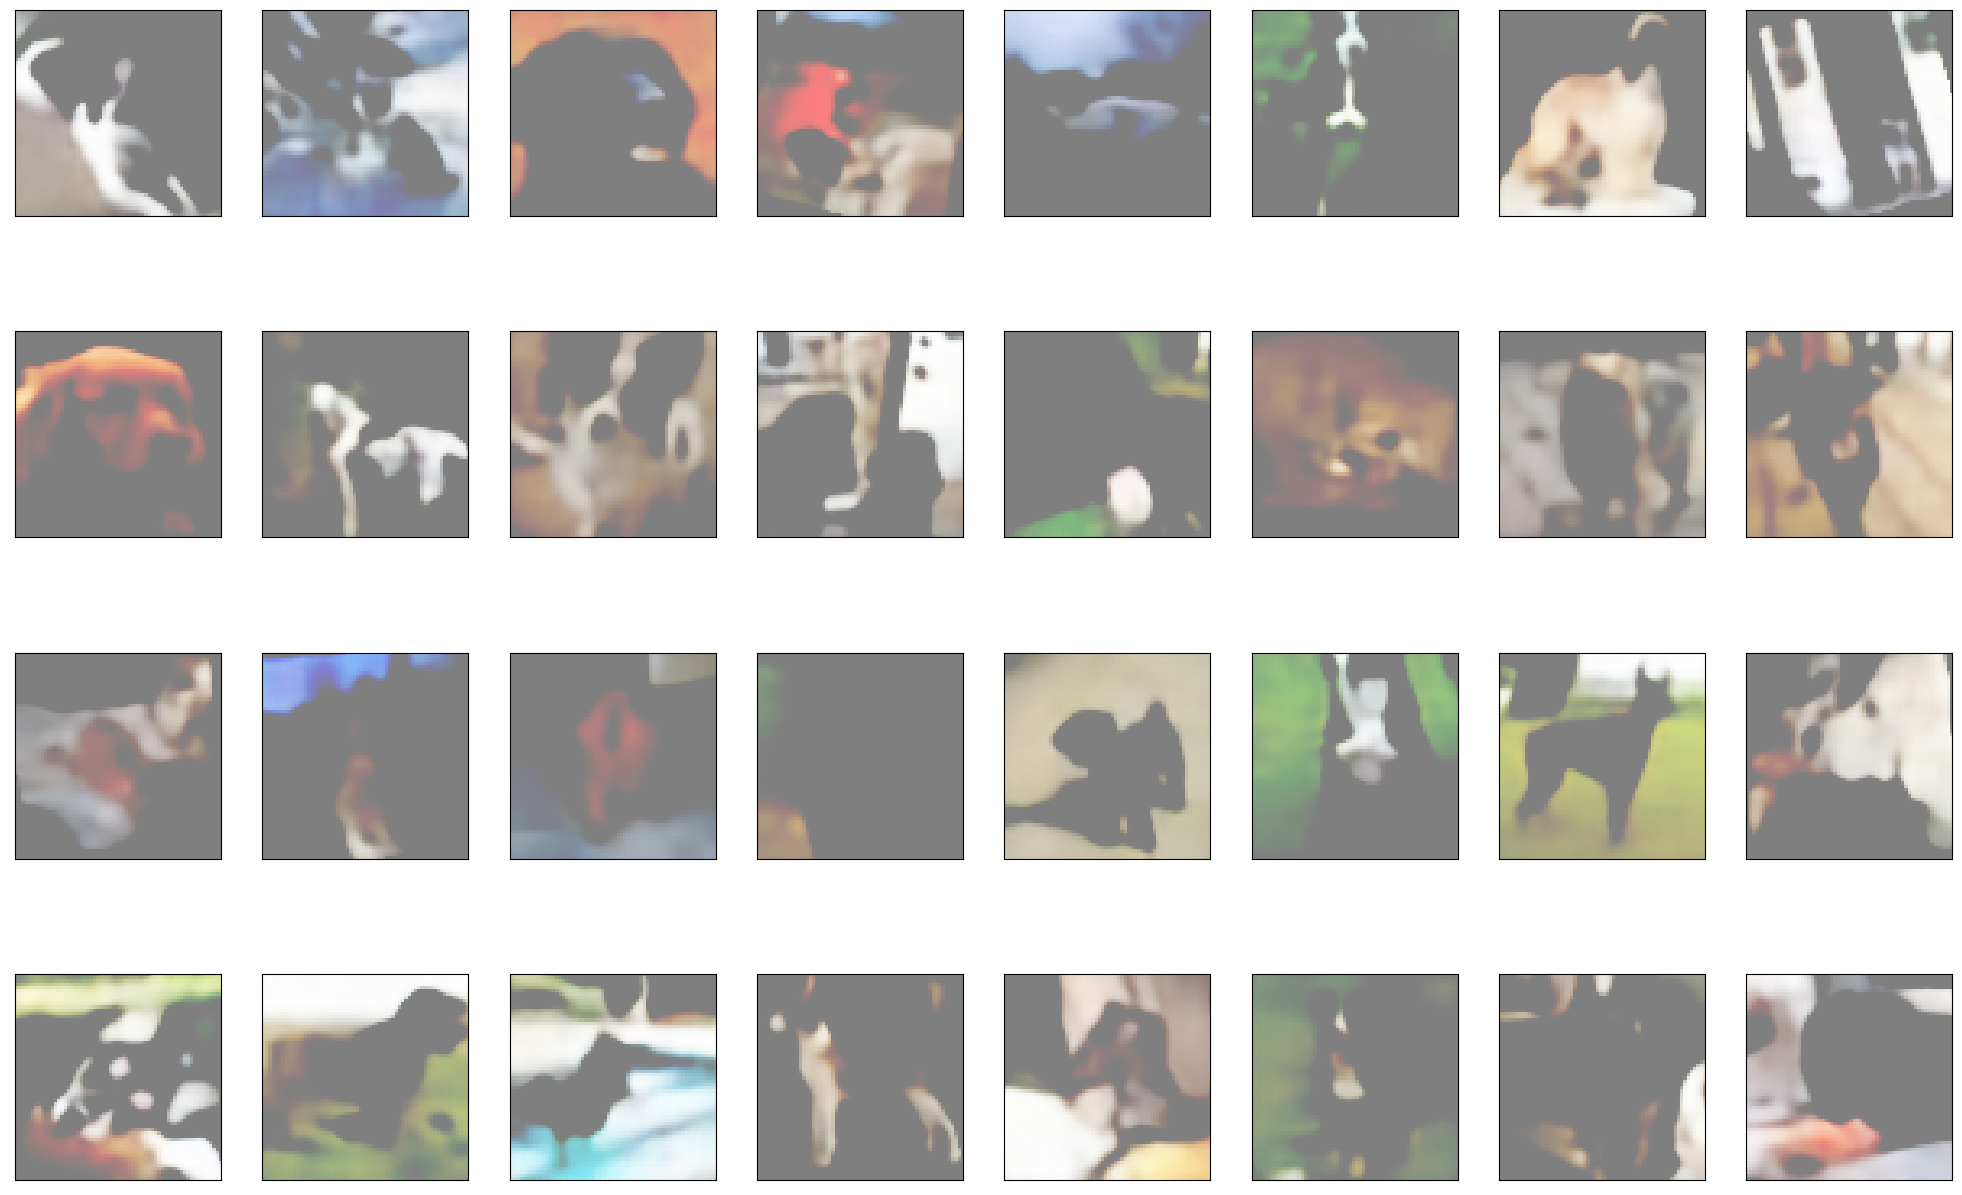

In [22]:
model.eval()
reconstructed, mu, _ = model(torch.tensor(imgs.transpose(0, 3, 1, 2)).to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

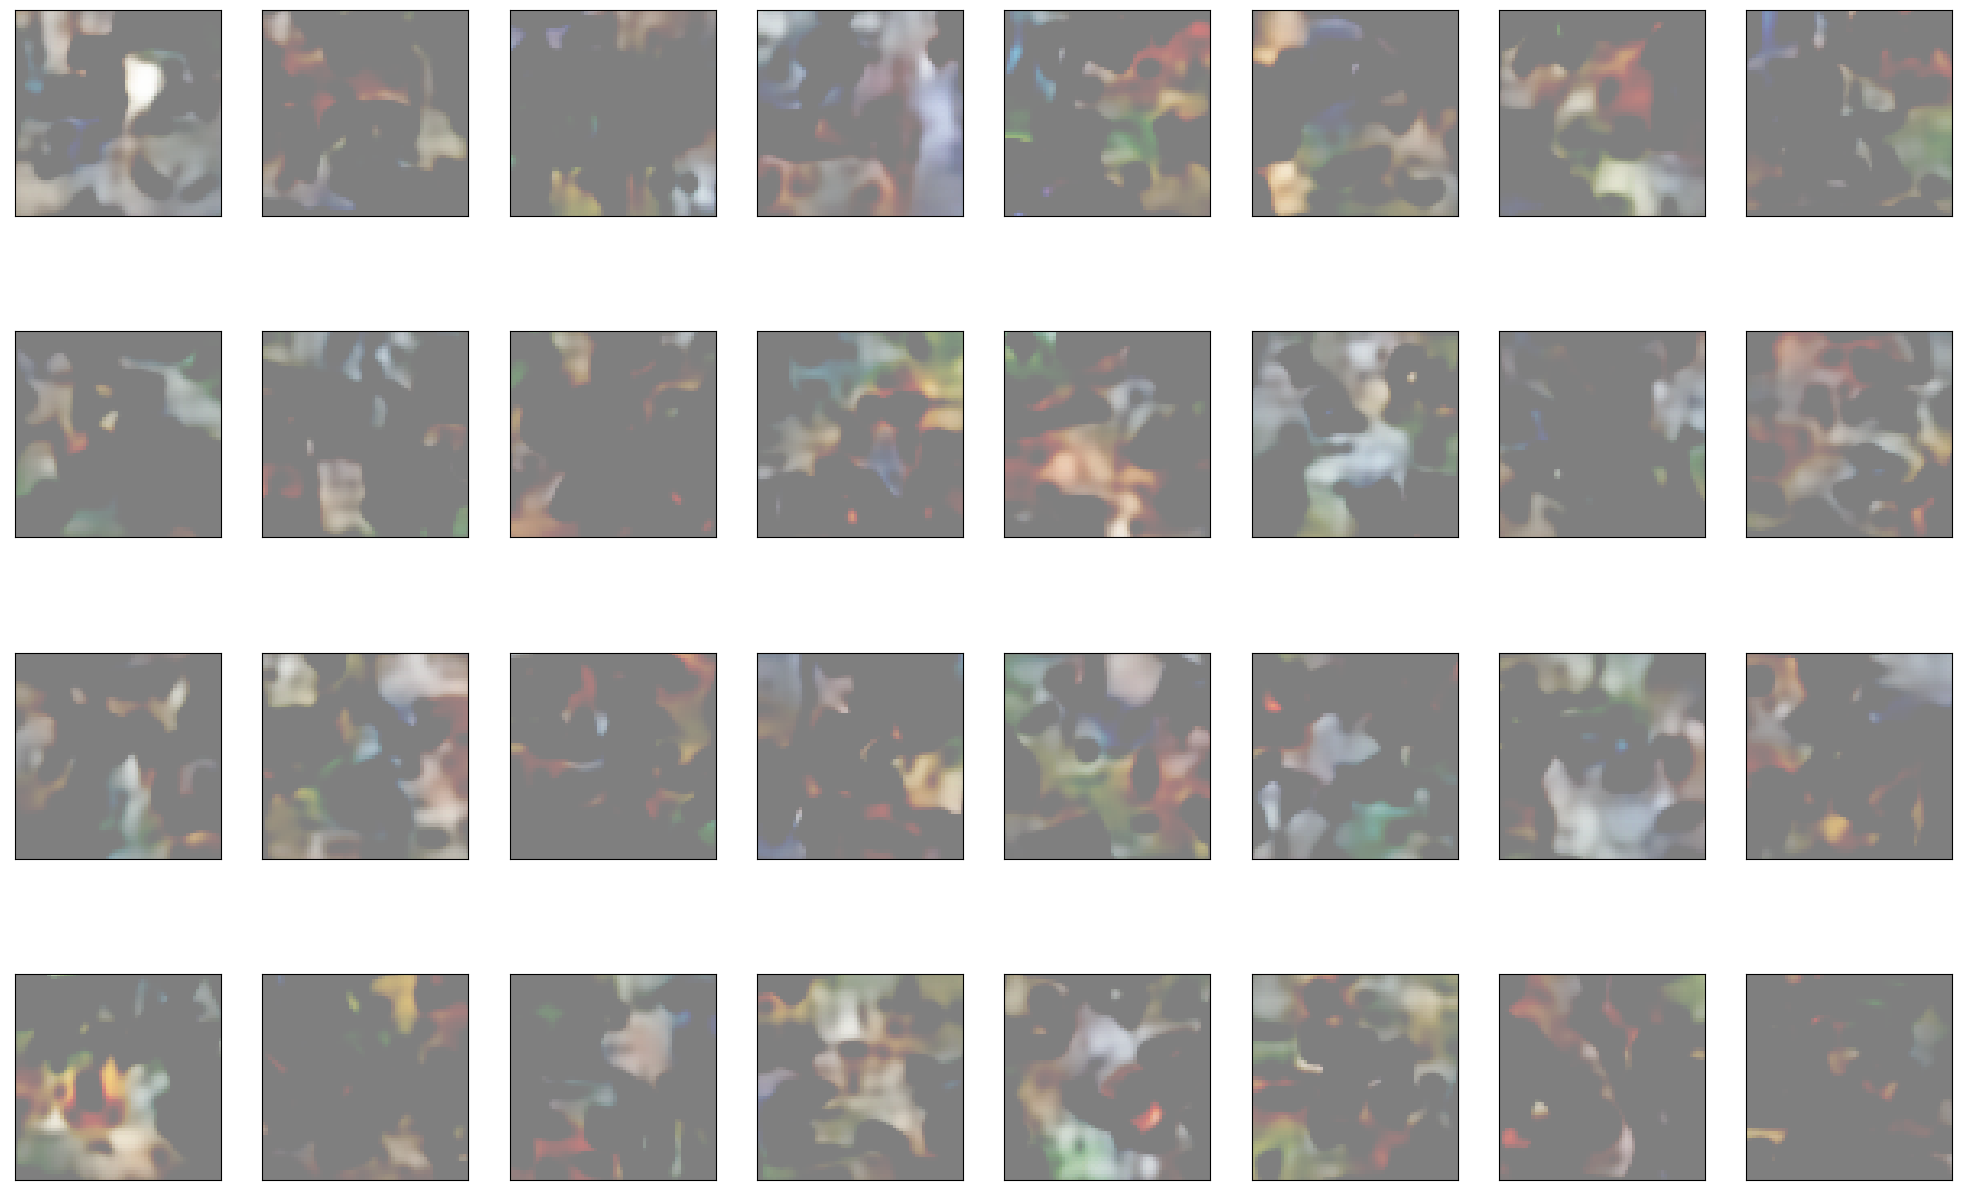

In [25]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

## Cropped images

In [26]:
lr = 1e-3
epochs = 15
latent_dim = 32

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

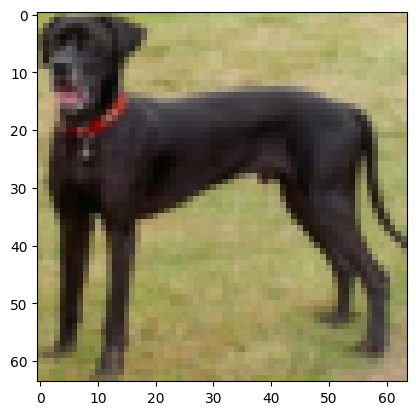

In [27]:
plt.imshow((imgs_cropped[0]+1)/2)
plt.show()

Starting epoch: 1
Loss: Total: 39228.62890625, MSE: 1638.6568603515625, KLD: 37589.97265625
Time for epoch 1: 186.5465886592865


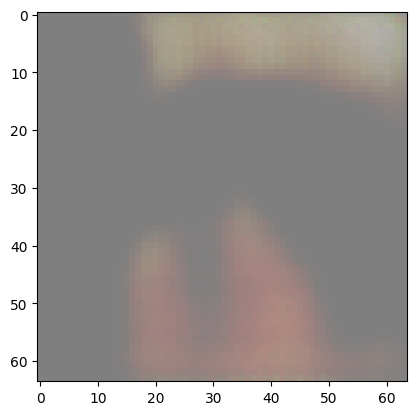

Starting epoch: 2
Loss: Total: 1531.26123046875, MSE: 1513.637939453125, KLD: 17.62322998046875
Time for epoch 2: 126.23255801200867


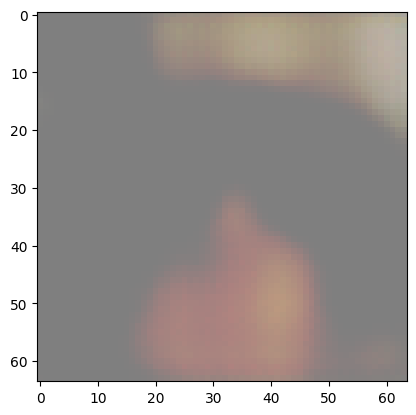

Starting epoch: 3
Loss: Total: 1505.0101318359375, MSE: 1487.4273681640625, KLD: 17.582799911499023
Time for epoch 3: 128.8652641773224


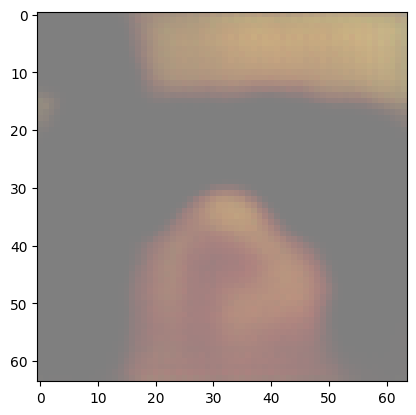

Starting epoch: 4
Loss: Total: 1491.489990234375, MSE: 1473.630859375, KLD: 17.859092712402344
Time for epoch 4: 133.23399758338928


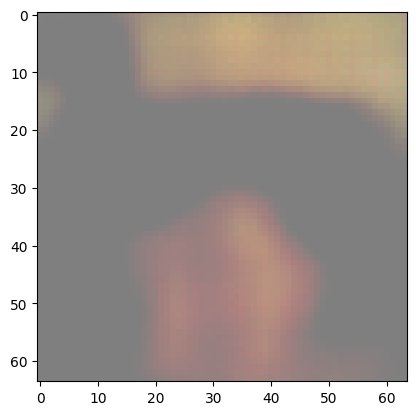

Starting epoch: 5
Loss: Total: 1480.3779296875, MSE: 1462.0185546875, KLD: 18.359317779541016
Time for epoch 5: 135.92258286476135


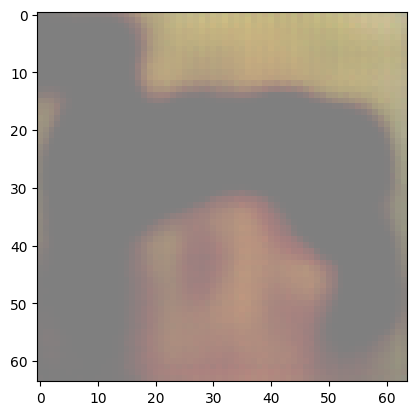

Starting epoch: 6
Loss: Total: 1467.9918212890625, MSE: 1449.04541015625, KLD: 18.946428298950195
Time for epoch 6: 308.39075541496277


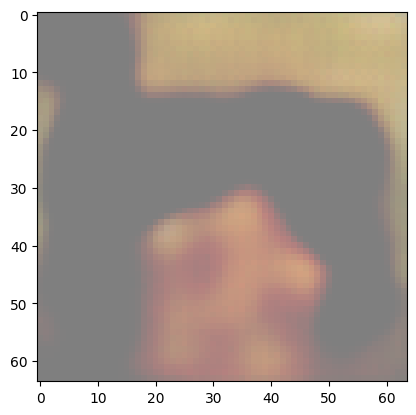

Starting epoch: 7
Loss: Total: 1458.3343505859375, MSE: 1437.480712890625, KLD: 20.85361099243164
Time for epoch 7: 345.1349174976349


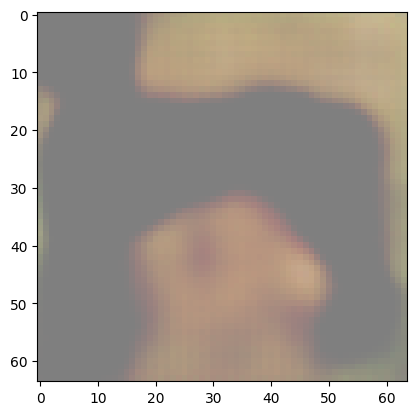

Starting epoch: 8
Loss: Total: 1451.4036865234375, MSE: 1429.8907470703125, KLD: 21.512977600097656
Time for epoch 8: 4500.868571281433


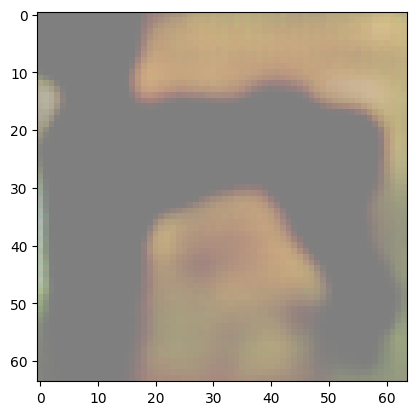

Starting epoch: 9


KeyboardInterrupt: 

In [29]:
mse_losses, kld_losses = train(model, cropped_data_loader, optimizer, epochs, imgs_cropped)

In [ ]:
# losses = {
#     'mse'
# }

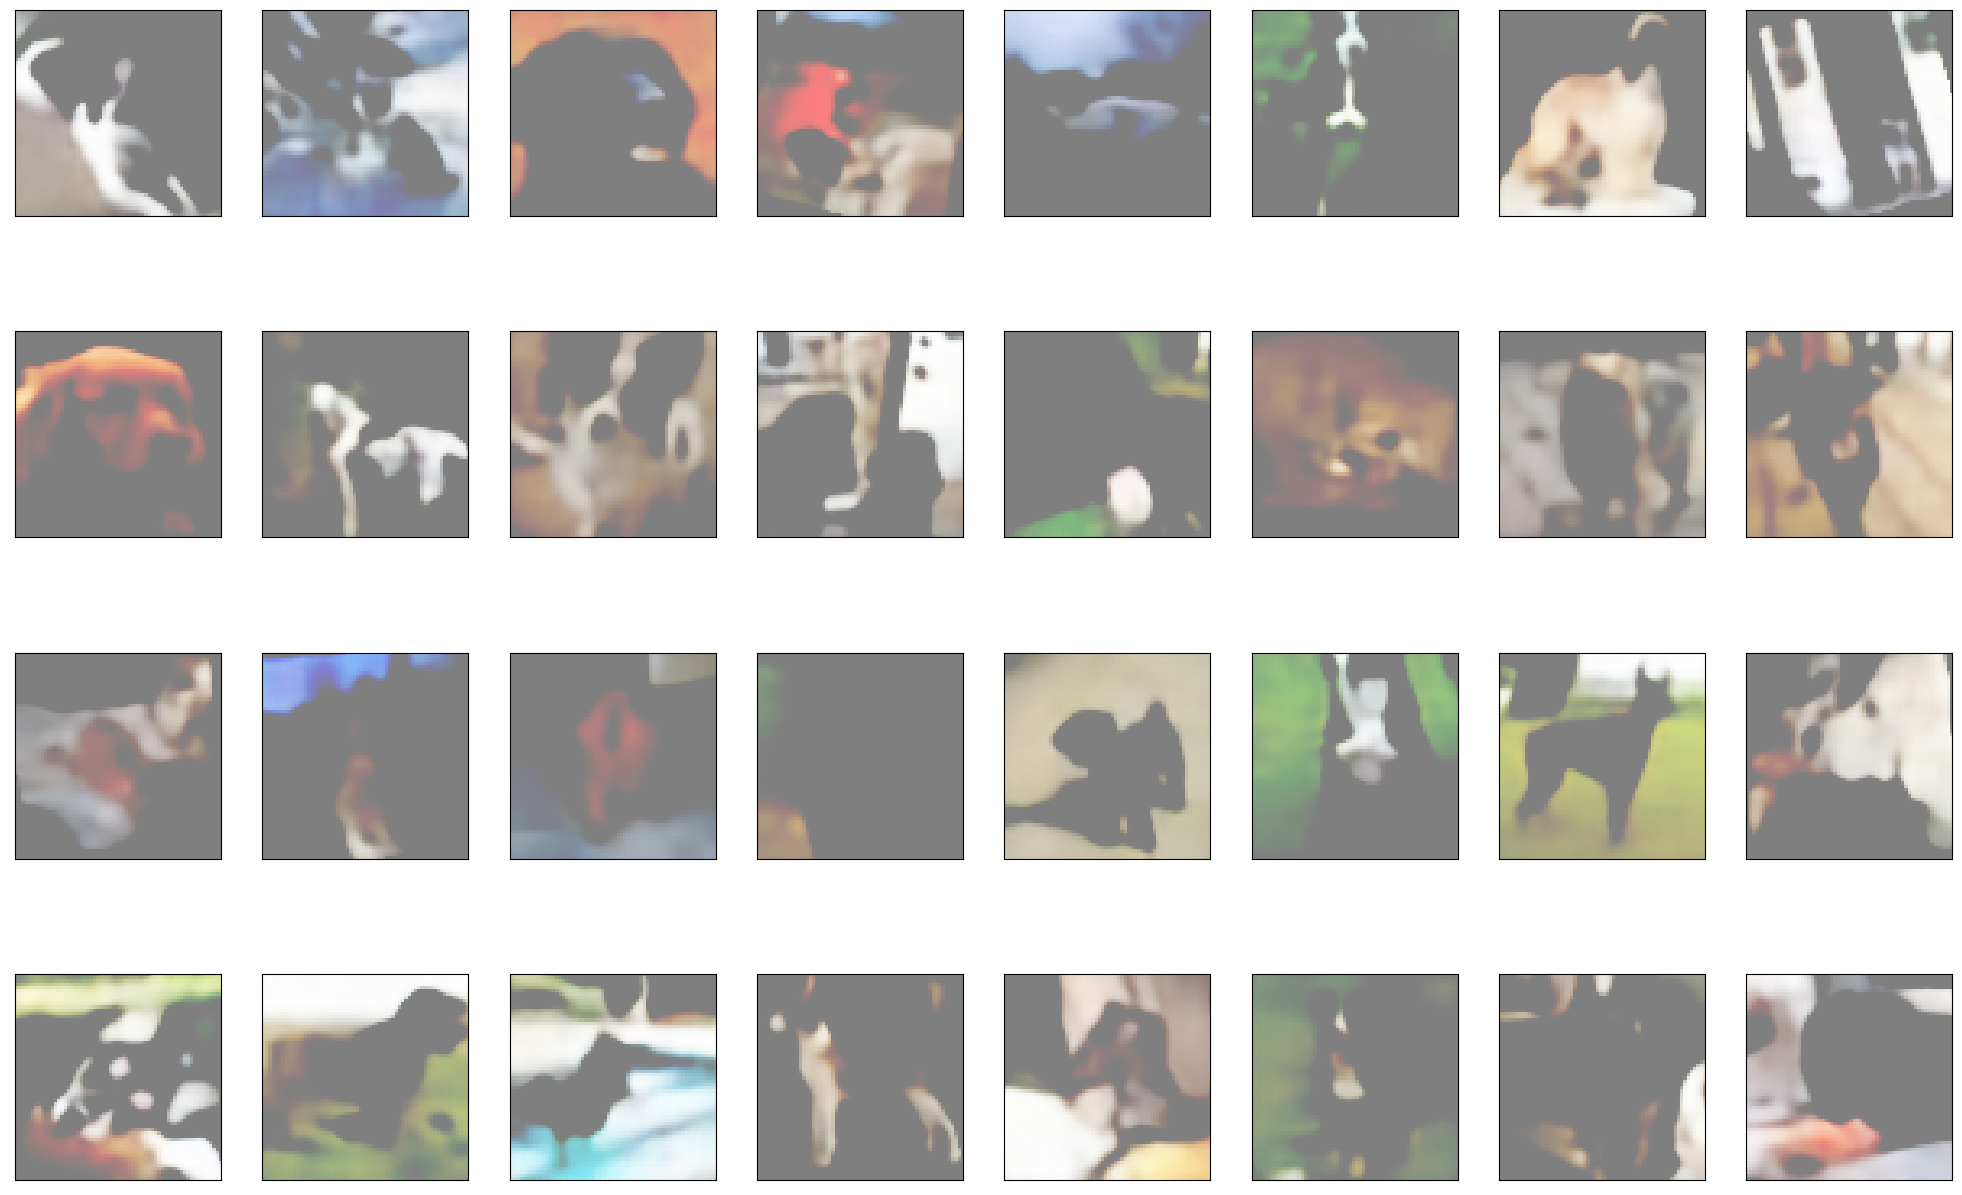

In [22]:
model.eval()
reconstructed, mu, _ = model(torch.tensor(imgs.transpose(0, 3, 1, 2)).to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

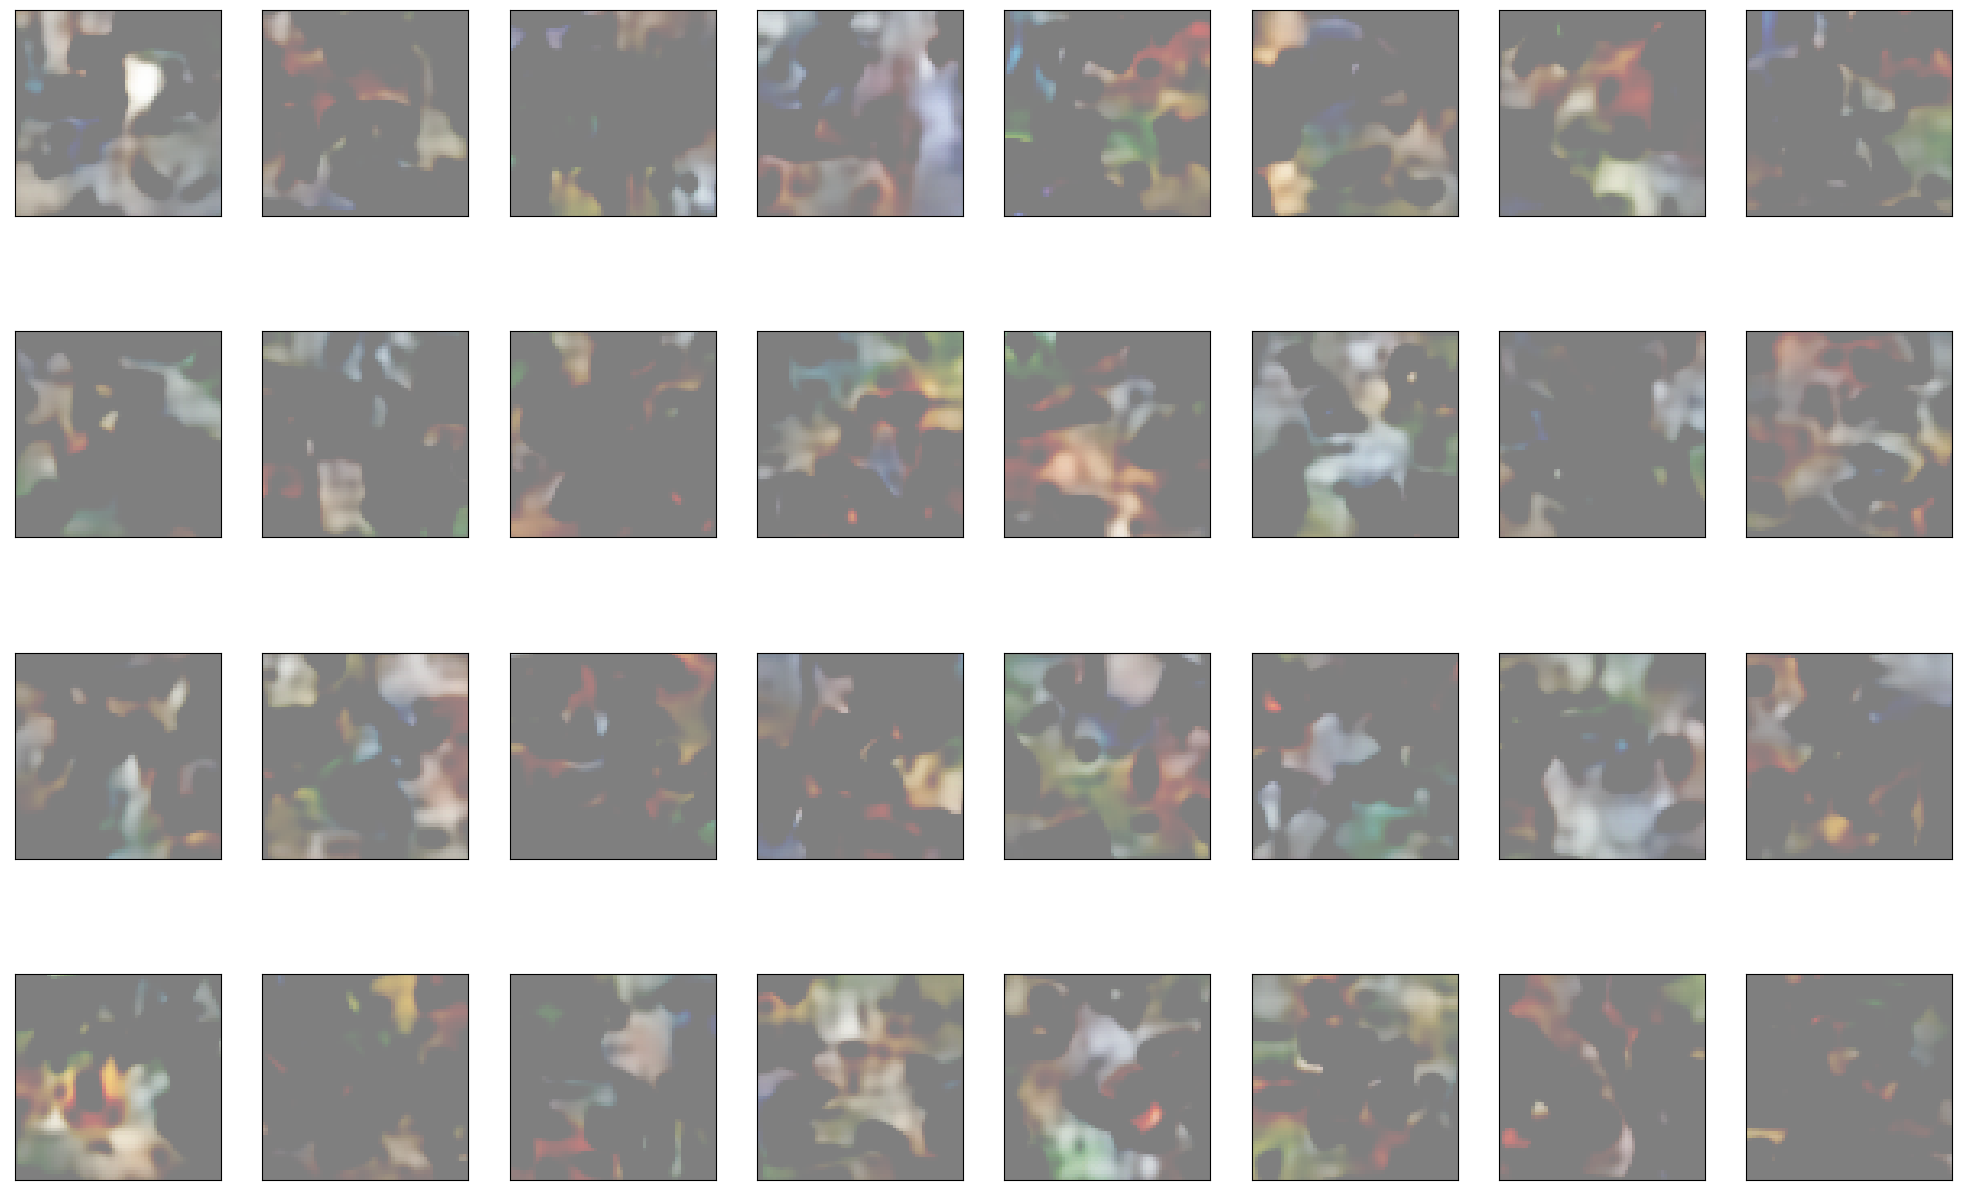

In [25]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)